___

<a href='http://www.dourthe.tech'> <img src='Dourthe_Technologies_Headers.png' /></a>
___
<center><em>For more information, visit <a href='http://www.dourthe.tech'>www.dourthe.tech</a></em></center>

# Implementation of the Pre-Trained YOLO Model for Automated Object Detection

___
## Objective
Build an algorithm enabling the automated detection and tracking of objects on images and videos using the pre-trained weights of the deep learning YOLO (You Only Look Once) model.

___
## YOLO
The YOLO algorithm is a unified deep learning convolutional neural network that predicts bounding boxes and class probability from images after only one evaluation (hence, You Only Look Once). That algorithm has the benefit of being extremely fast compared to other deep learning models.

_For more details on YOLO, please visit https://arxiv.org/pdf/1506.02640v5.pdf_

___
## COCO
COCO is a large-scale dataset that contains over 1.5 million images with 80 different classes. The YOLO algorithm was trained on that dataset, and the resulting weights are now publicly available.

_For more details on YOLO, please visit http://cocodataset.org/#home_

___
## Setup
In order to use the YOLO algorithm and its pre-trained weights on the COCO dataset, please follow these steps:

**Source Code**
- Go to https://github.com/xiaochus/YOLOv3
- Clone/download the original repository and write your script/notebook in this specific directory
- Download the _yolov3.weights_ file and move it to the repository you just cloned/downloaded
- Open a Command Prompt/Terminal and go to the cloned/downloaded directory by typing: _cd folder path_ 
- Copy this code to convert the _yolov3.weights_ file to an .h5 file that can be read by python: _python yad2k.py cfg\yolo.cfg yolov3.weights data\yolo.h5_

___
## Algorithm preview
The algorithm results in images/videos where each identified object is contoured by a rectangle, around which the corresponding object label and probability is displayed.

**Example on single images**

<img src="img/image_example_1.png" alt="Drawing" style="width: 500px;"/>
<img src="img/image_example_2.png" alt="Drawing" style="width: 500px;"/>
<img src="img/image_example_3.png" alt="Drawing" style="width: 500px;"/>
<img src="img/image_example_4.png" alt="Drawing" style="width: 500px;"/>

**Example on videos (screenshots from processed videos)**

<img src="img/living_room_example.jpg" alt="Drawing" style="width: 1000px;"/>
<img src="img/rainy_street_example.jpg" alt="Drawing" style="width: 1000px;"/>

___
## Libraries Imports
### Data manipulation and analysis

In [1]:
import os
import numpy as np

### Data visualization

In [2]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

### Computer vision

In [3]:
import cv2

### Machine learning

In [5]:
from model.yolo_model import YOLO

___
## Data Import and Visualization
**We will start by creating a list containing the filenames of all images and videos contained in the _data_ folder.**

In [6]:
images = os.listdir('data/image-samples')
videos = os.listdir('data/video-samples')

**Let's load and display the first few images.**
Note that using the _imshow_ method from the cv2 library require to open a separate window. In order to visualize the image within the notebook, we will use _imshow_ method from matplotlib instead.

However, since cv2 reads image with a Blue, Green, Red (BGR) color convention, we need to use the cvtColor method from cv2 to convert the color channels from BGR to Red, Green, Blue (RGB).

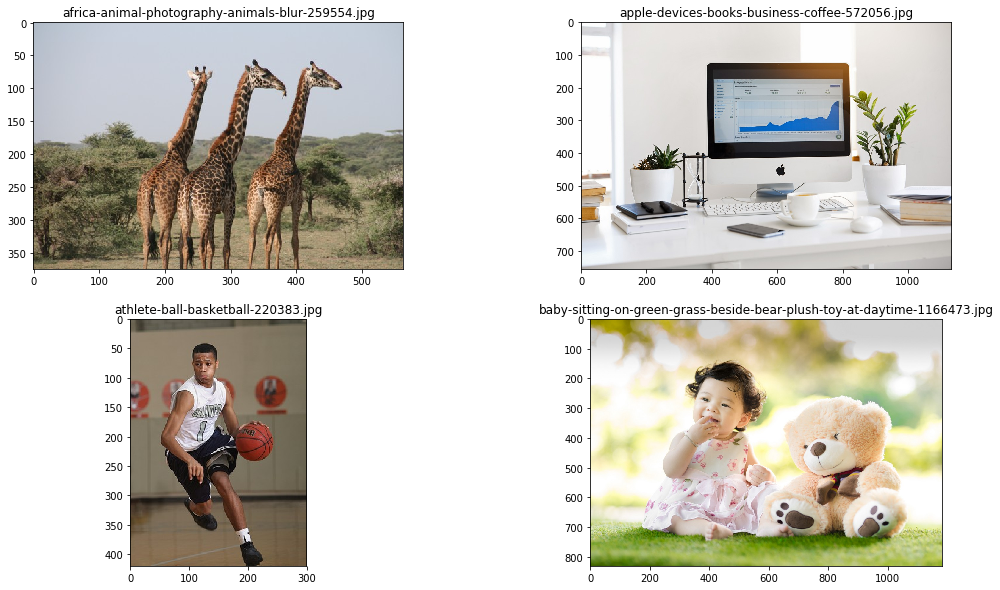

In [83]:
plt.figure(figsize=(18,10))

plt.subplot(221)
img = cv2.imread('data/image-samples/' + images[0])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(images[0])

plt.subplot(222)
img = cv2.imread('data/image-samples/' + images[1])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(images[1])

plt.subplot(223)
img = cv2.imread('data/image-samples/' + images[2])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(images[2])

plt.subplot(224)
img = cv2.imread('data/image-samples/' + images[3])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(images[3])

plt.show()

___
## YOLO Implementation
### Load model
**Here, we can load the YOLO model with defined threshold values for the object and for the box.**

For instance, an object threshold of 0.5 means that when an object is detected, the model will attribute the class that has a probability of 0.5 (50%) or higher to that object.

In [9]:
yolo = YOLO(0.4,0.4)

### Load classes
**When the repository is cloned/downloaded, a textfile named _coco_classes_ should appear in the _data_ folder. That textfile contains the name of all classes present in the COCO dataset, i.e. all classes that the model can potentially identify.**

Here, we will open the text file and create a list containing all available classes.

In [8]:
with open('data/coco_classes.txt') as classes_txt:
    coco_classes = classes_txt.readlines()
    coco_classes = [c.strip() for c in coco_classes]
print(coco_classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


To better visualize each detected object, we will also define a dictionary of color with random color codes for each class.

In [10]:
colors = {k: (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))  for k in coco_classes}

### Define pre-processing functions
**For the model to work on any image/video format, we need to create a function that will take each image/frame and convert it to a format that the YOLO model can read and process.**

In [11]:
def img_process(img):
    
    # Resize image/frame to the right width and height
    processed_img = cv2.resize(img, (416, 416), interpolation=cv2.INTER_CUBIC)
    
    # Convert to float
    processed_img = np.array(processed_img, dtype='float32')
    
    # Normalize pixels value between 0 and 1
    processed_img /= 255.
    
    # Add one dimension that corresponds the the sample number, resulting in a final shape of (1, 416, 416, 3)
    processed_img = np.expand_dims(processed_img, axis=0)
    
    return processed_img

**Let's visualize the output of the img_format function on the first image of the _image-samples_ folder.**

_Note that we need to squeeze the processed image (i.e. remove the dimension along axis 0 that was added in the function) to allow visualization._

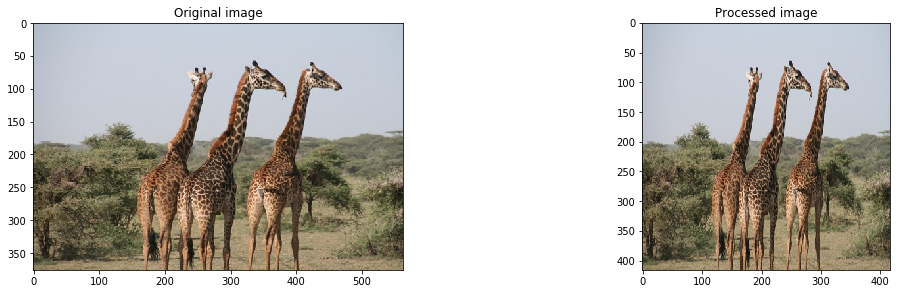

In [59]:
plt.figure(figsize=(18,10))

plt.subplot(221)
img = cv2.imread('data/image-samples/' + images[0])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original image')

plt.subplot(222)
processed_img = np.squeeze(img_process(img), axis=0)
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.title('Processed image')

plt.show()

**Next, we need to create a function that will draw a bounding box around each detected object. The function will also write the detected class, along with the probability score.**

_e.g. a probability score of 0.90 would indicate that the model is 90% certain that the predicted class is correct)._

In [12]:
def draw_bbox(img, boxes, scores, classes, list_of_classes):

    for box, score, c in zip(boxes, scores, classes):
        
        x, y, w, h = box

        top = max(0, np.floor(x + 0.5).astype(int))
        left = max(0, np.floor(y + 0.5).astype(int))
        right = min(img.shape[1], np.floor(x + w + 0.5).astype(int))
        bottom = min(img.shape[0], np.floor(y + h + 0.5).astype(int))
        
        # Draw rectangle around detected object
        cv2.rectangle(img, (top, left), (right, bottom), colors[list_of_classes[c]], 2)
        
        # Add text indicating the class of the detected object
        cv2.putText(img, '{0} {1:.2f}'.format(list_of_classes[c], score),
                    (top, left - 6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, colors[list_of_classes[c]], 1,
                    cv2.LINE_AA)

### Test on single image
**We will start by defining a function that pre-processes the imported image/frame, then applies the YOLO model to the resulting processed image and displays the results.**

In [13]:
def apply_yolo_img(img):
    
    # Pre-process image
    processed_img = img_process(img)
    
    # Generate YOLO prediction from processed image
    boxes, classes, scores = yolo.predict(processed_img, img.shape)
    
    # Draw bounding boxes and display classes and scores on image
    if boxes is not None:
        draw_bbox(img, boxes, scores, classes, coco_classes)
           
    # Display results
    plt.figure(figsize=(12,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()  

**Let's try this algorithm on a few random images from the _image-samples_ folder.**

Applying YOLO object detection to: baseball-player-batting-photography-159550.jpg


<Figure size 1296x720 with 0 Axes>

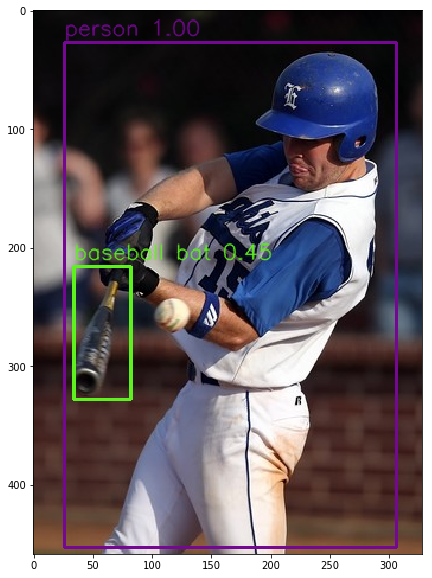

Applying YOLO object detection to: baby-sitting-on-green-grass-beside-bear-plush-toy-at-daytime-1166473.jpg


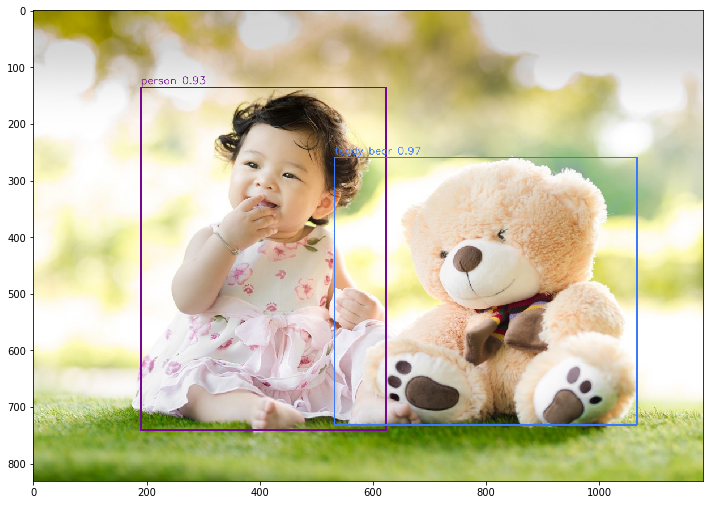

Applying YOLO object detection to: two-yellow-labrador-retriever-puppies-1108099.jpg


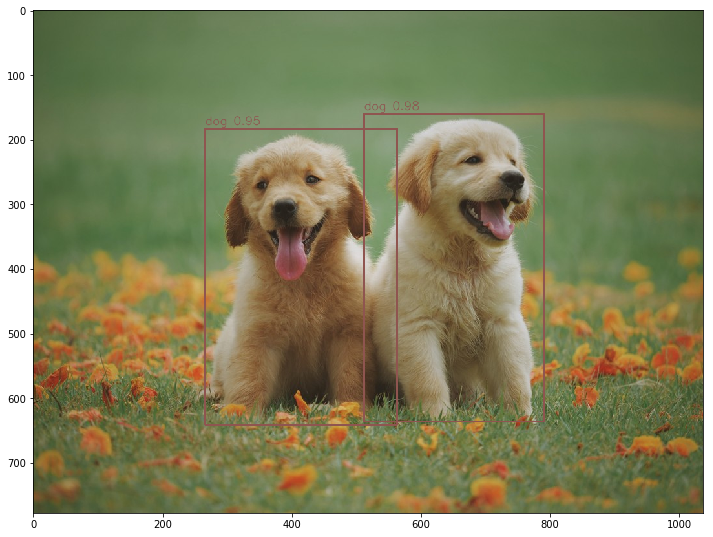

Applying YOLO object detection to: photo-of-a-group-of-horses-2123766.jpg


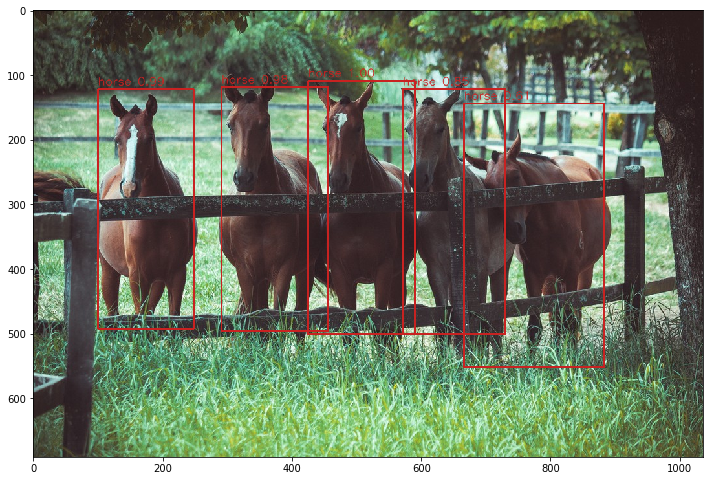

Applying YOLO object detection to: black-kettle-beside-condiment-shakers-and-green-fruits-and-1080696.jpg


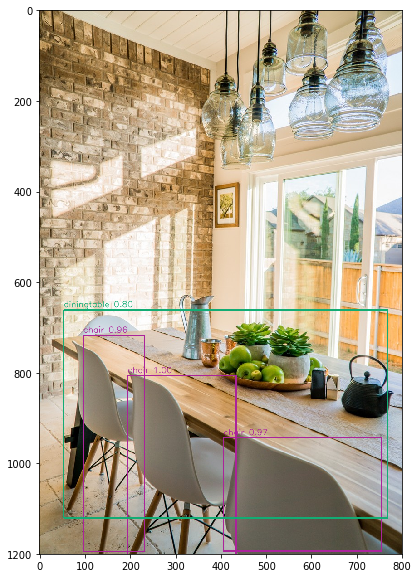

Applying YOLO object detection to: stop-sign-on-the-street-4061973.jpg


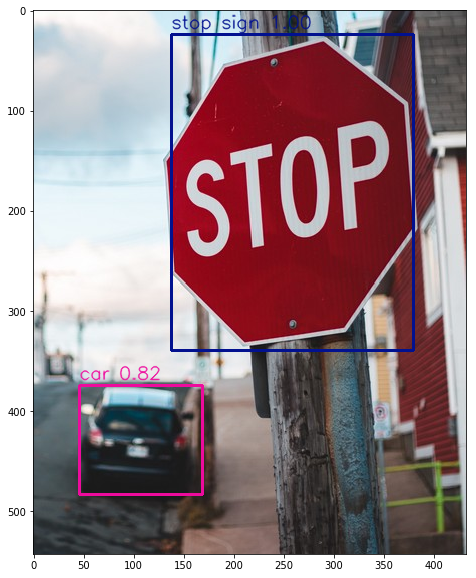

In [84]:
rand_idx = np.random.randint(0,len(images),6)

for idx in rand_idx:
    
    img = cv2.imread('data/image-samples/' + images[idx])

    print('Applying YOLO object detection to: ' + images[idx])
    apply_yolo_img(img)

### Video implementation
**We will define a function that applies the same method used above to every frame of a video.**

***Notes:***
* _Since the live feed may be significantly slowed down by the prediction process, we will save the results as a separate video file instead of displaying the live predictions frame by frame._
* _Depending on your computer's memory, certain videos may require GPU acceleration to be fully processed._
* _The option to resize the video is also available by defining a resize ratio as a percentage of the original frame size._

In [12]:
def apply_yolo_vid(video, model, list_of_classes):  

    cap = cv2.VideoCapture('data/video-samples/' + video)
    
    # Count total number of frames in video
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    current_frame = 1
    
    # Define resize ratio as a percentage of the original size
    resize_ratio = 100
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * resize_ratio / 100)
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * resize_ratio / 100)
    dim = (width, height)
    
    # Define number of frames to process as a percentage of the total number of frames
    process_length_ratio = 100
    max_frame = int(process_length_ratio/100*num_frames)    

    # Initialize video saving
    dims = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = cv2.VideoWriter_fourcc(*'mpeg')    
    vid_save = cv2.VideoWriter()
    vid_save.open('results/yolo_' + video, fourcc, 20, dims, True)    
    
    # Initialize time counter
    start = time.time()

    while True:
        
        clear_output()
        print('VIDEO PROCESSING IN PROGRESS\t')
        print('\tFilename:\t\t', video)
        print('\tProcessing frame:\t', current_frame, '/', max_frame)
        if current_frame == 1:
            print('\tTime elasped:\t\t 0 hrs 0 mins 0 secs')
            print('\tRemaining time: \t estimation in progress...')
        else:
            print('\tTime elasped:\t\t', el_time_hr, 'hrs', el_time_min, 'mins', el_time_sec, 'secs')
            print('\tRemaining time: \t', rem_time_hr, 'hrs', rem_time_min, 'mins', rem_time_sec, 'secs')
        
        res, frame = cap.read()
        frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

        if not res:
            break
            
        processed_img = img_process(frame)

        boxes, classes, scores = yolo.predict(processed_img, frame.shape)

        if boxes is not None:
            draw_bbox(frame, boxes, scores, classes, coco_classes)

        # Save the video frame by frame
        vid_save.write(frame)

        if cv2.waitKey(110) & 0xff == 27:
            break       
        
        # Estimate total processing time based on time to process first frame
        if current_frame == 1:
            frame_time = time.time() - start
            est_total_time = frame_time*max_frame
            
        # Calculate time elapsed
        el_time = time.time() - start
        el_time_hr = int(el_time//3600)
        el_time_min = int((el_time - el_time_hr*3600)//60)
        el_time_sec = int((el_time - el_time_hr*3600)%60)
            
        # Estimate remaining processing time
        rem_time = est_total_time - frame_time*current_frame
        rem_time_hr = int(rem_time//3600)
        rem_time_min = int((rem_time - rem_time_hr*3600)//60)
        rem_time_sec = int((rem_time - rem_time_hr*3600)%60)
        
        # Update frame number
        current_frame += 1
        
        # Break if max number of frames has been reached
        if current_frame == max_frame:
            break

    vid_save.release()
    cap.release()
    
    clear_output()
    print('VIDEO PROCESSING IN PROGRESS\t')
    print('\tFilename:\t\t', video)
    print('\tProcessing frame:\t', current_frame, '/', max_frame)
    print('\tTime elasped:\t\t', el_time_hr, 'hrs', el_time_min, 'mins', el_time_sec, 'secs')
    print('\tRemaining time: \t', rem_time_hr, 'hrs', rem_time_min, 'mins', rem_time_sec, 'secs')
    print('Total computation time:\t\t', el_time_hr, 'hrs', el_time_min, 'mins', el_time_sec, 'secs')

**Finally, let's apply the YOLO model to a video.**

_Note: processing videos can take a long time depending on your computer power._

In [16]:
apply_yolo_vid(videos[4], yolo, coco_classes)

VIDEO PROCESSING IN PROGRESS	
	Filename:		 Rainy street.mp4
	Processing frame:	 158 / 158
	Time elasped:		 2 hrs 40 mins 29 secs
	Remaining time: 	 0 hrs 0 mins 39 secs
Total computation time:		 2 hrs 40 mins 29 secs
